### Домашнее задание 2

Выполнил Козин Роман

Для начала отберём 10 классов для работы с ними

In [1]:
import random
random.seed(52)
CLASS_NUM = 10
classes_path = './data/tiny-imagenet-200/tiny-imagenet-200/wnids.txt'
with open(classes_path) as f:
    ids = f.read().split('\n')
print(ids)

['n02124075', 'n04067472', 'n04540053', 'n04099969', 'n07749582', 'n01641577', 'n02802426', 'n09246464', 'n07920052', 'n03970156', 'n03891332', 'n02106662', 'n03201208', 'n02279972', 'n02132136', 'n04146614', 'n07873807', 'n02364673', 'n04507155', 'n03854065', 'n03838899', 'n03733131', 'n01443537', 'n07875152', 'n03544143', 'n09428293', 'n03085013', 'n02437312', 'n07614500', 'n03804744', 'n04265275', 'n02963159', 'n02486410', 'n01944390', 'n09256479', 'n02058221', 'n04275548', 'n02321529', 'n02769748', 'n02099712', 'n07695742', 'n02056570', 'n02281406', 'n01774750', 'n02509815', 'n03983396', 'n07753592', 'n04254777', 'n02233338', 'n04008634', 'n02823428', 'n02236044', 'n03393912', 'n07583066', 'n04074963', 'n01629819', 'n09332890', 'n02481823', 'n03902125', 'n03404251', 'n09193705', 'n03637318', 'n04456115', 'n02666196', 'n03796401', 'n02795169', 'n02123045', 'n01855672', 'n01882714', 'n02917067', 'n02988304', 'n04398044', 'n02843684', 'n02423022', 'n02669723', 'n04465501', 'n02165456'

Возьмём случайные десять классов, в исходном текстовом файле была пустая строка, учтём это при отборе случайных классов

In [2]:
selected_classes = random.sample(ids[:-1], CLASS_NUM)
print(selected_classes)

['n01882714', 'n02279972', 'n02699494', 'n02123394', 'n03026506', 'n01910747', 'n04532106', 'n07920052', 'n02058221', 'n07695742']


Вот наши классы, чтобы случайно не потерять их, выпишем их в список явно

In [3]:
selected_classes = ['n01882714', 'n02279972', 'n02699494', 'n02123394', 'n03026506', 'n01910747', 'n04532106', 'n07920052', 'n02058221', 'n07695742']

## Часть 1: Подготовка данных

Создание датакласса
Реализуйте собственный класс TinyImageNetDataset, наследующий от torch.utils.data.Dataset:

* Метод ```__init__```: инициализация путей к данным, загрузка списка изображений и меток
* Метод ```__len__```: возврат количества примеров в датасете
* Метод ```__getitem__```: загрузка и возврат одного примера (изображение + метка)

In [4]:
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from PIL import Image
import torch
import os
class SmallDataset(Dataset):
    def __init__(self, root: str, classes: list[str], ds_type: str, device = torch.device("cpu"), transform = None) -> None:
        super().__init__()
        self.ds_type = ds_type
        self.root = root
        self.classes = classes
        if ds_type == 'val':
            self.prepareValData()
        self.device = device
        self.transform = transform
        self.label_to_idx = {label : idx for idx, label in enumerate(classes)}
        
    def prepareValData(self) -> None:
        self.valData = []
        labelsSet = set(self.classes)
        with open(os.path.join(self.root, self.ds_type, "val_annotations.txt")) as f:
            rows = f.readlines()
            f.close()    
        for row in rows:
            data = self._parseLine(row)
            label = data[1]
            if label in labelsSet:
                self.valData.append(tuple(data))
    
    def _parseLine(self, row: str):
        els = row.split("\t")
        data = [els[k].strip("\n") for k in range(len(els))]
        if self.ds_type == 'val':
            start_idx = 2
        else:
            start_idx = 1
        for i in range(start_idx, len(data)):
            data[i] = int(data[i])
        return data
    
    def __getitem__(self, index: int):
        if self.ds_type == 'val':
            data = self.valData[index]
            img_path = os.path.join(self.root, self.ds_type, "images", data[0])
            label = data[1]
            bbox = tuple(data[2:])
        else:
            label_idx = index // 500
            img_idx = index % 500
            label = self.classes[label_idx]
            label_root = os.path.join(self.root, self.ds_type, label)
            img_path = os.path.join(label_root, "images", f'{label}_{img_idx}.JPEG')
            with open(os.path.join(label_root, f"{label}_boxes.txt")) as f:
                rows = f.readlines()
                f.close()
            row = rows[img_idx]
            data = self._parseLine(row)
            bbox = tuple(data[1:])
        
        bbox = torch.tensor(bbox).to(self.device)
        img = Image.open(img_path).convert('RGB')
            
        if self.transform:
            img = self.transform(img)
        return (img.to(self.device), torch.tensor(self.label_to_idx[label]).to(self.device), bbox)
        
    def __len__(self) -> int:
        #структура исходного датасета такова, что на каждый класс приходится 500 изображений
        if self.ds_type == 'train':
            return len(self.classes) * 500
        else:
            return len(self.valData)

In [5]:
ds = SmallDataset("data\\tiny-imagenet-200\\tiny-imagenet-200", classes=selected_classes, ds_type='train')

## Часть 2: Базовая архитектура ResNet18

### 2.1. Реализация Basic Block

Создайте базовый residual блок со следующей структурой:

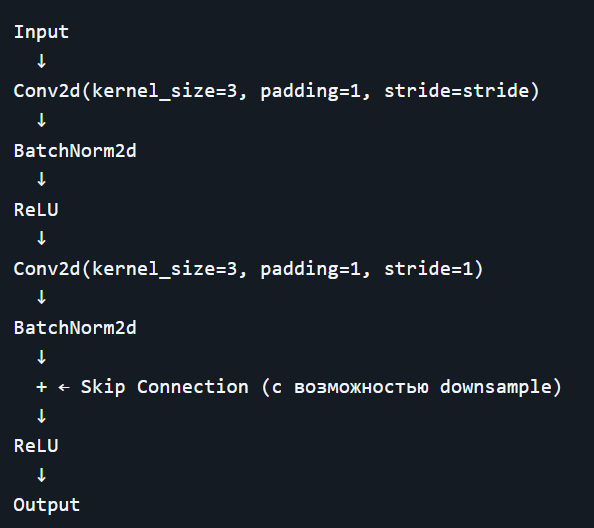

Важно:

* Если входные и выходные размерности не совпадают, используйте skip connection с Conv2d(1x1) + BatchNorm2d
* Первый residual блок может иметь stride=2 для уменьшения пространственного размера

In [6]:
import torch.nn as nn

class BasicResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1, stride=stride),
            nn.BatchNorm2d(in_channels),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(out_channels),
        )
        self.downsample = None
        if in_channels != out_channels or stride > 1:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )
        self.relu = nn.ReLU()
            
    def forward(self, x):
        identity = x
        res = self.conv1(x)
        res = self.conv2(res)
        if self.downsample:
            identity = self.downsample(identity)
        res = res + identity
        res = self.relu(res)
        return res

In [7]:
x = torch.randn(1, 3, 64, 64)

model = BasicResBlock(3, 16, stride=2)
print(model(x).shape)

torch.Size([1, 16, 32, 32])


### 2.2 Реализация ResNet18

Создайте архитектуру ResNet18 со следующей структурой:

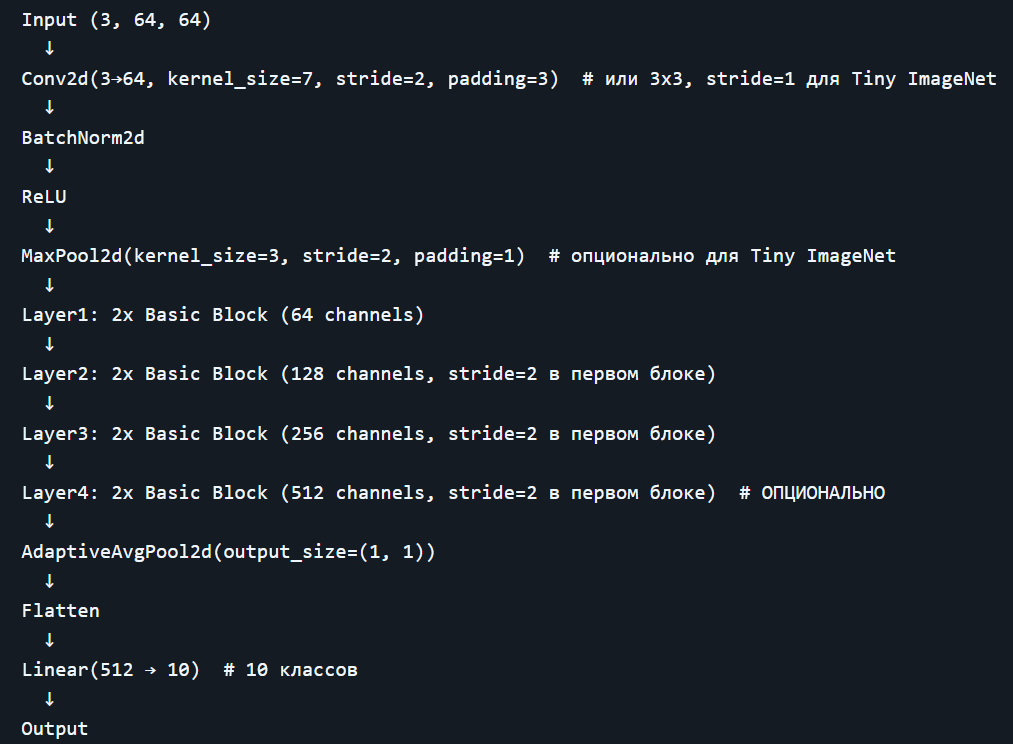

In [8]:
class ResNet18(nn.Module):
    def __init__(self, in_channels, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.initConv = nn.Sequential(  # 64, 32, 32
            nn.Conv2d(in_channels, out_channels=64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        
        self.layer1 = nn.Sequential(    #128, 32, 32
            BasicResBlock(in_channels=64, out_channels=64, stride=1),
            BasicResBlock(in_channels=64, out_channels=128, stride=1),
        )
        self.layer2 = nn.Sequential(    #256, 16, 16
            BasicResBlock(in_channels=128, out_channels=128, stride=2),
            BasicResBlock(in_channels=128, out_channels=256, stride=1)
        )
        self.layer3 = nn.Sequential(    #512, 8, 8
            BasicResBlock(in_channels=256, out_channels=256, stride=2),
            BasicResBlock(in_channels=256, out_channels=512, stride=1)
        )
        self.avg = nn.AdaptiveAvgPool2d(output_size=(1,1))
        self.fc = nn.Linear(in_features=512, out_features=10)
    
    def forward(self, x):
        x = self.initConv(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.avg(self.layer3(x))
        x = x.flatten(1)
        x = self.fc(x)
        return x

In [9]:
from torchsummary import summary

In [10]:
x = torch.randn((1, 3, 64, 64))
model = ResNet18(3)
print(model(x).shape)
summary(model, input_size=(3, 64, 64), batch_size=1)

torch.Size([1, 10])
Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       1,792
|    └─BatchNorm2d: 2-2                  128
|    └─ReLU: 2-3                         --
├─Sequential: 1-2                        --
|    └─BasicResBlock: 2-4                --
|    |    └─Sequential: 3-1              37,056
|    |    └─Sequential: 3-2              37,056
|    |    └─ReLU: 3-3                    --
|    └─BasicResBlock: 2-5                --
|    |    └─Sequential: 3-4              37,056
|    |    └─Sequential: 3-5              74,112
|    |    └─Sequential: 3-6              8,576
|    |    └─ReLU: 3-7                    --
├─Sequential: 1-3                        --
|    └─BasicResBlock: 2-6                --
|    |    └─Sequential: 3-8              147,840
|    |    └─Sequential: 3-9              147,840
|    |    └─Sequential: 3-10             16,768
|    |    └─ReLU: 3-11                   --
|    └─BasicRe

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       1,792
|    └─BatchNorm2d: 2-2                  128
|    └─ReLU: 2-3                         --
├─Sequential: 1-2                        --
|    └─BasicResBlock: 2-4                --
|    |    └─Sequential: 3-1              37,056
|    |    └─Sequential: 3-2              37,056
|    |    └─ReLU: 3-3                    --
|    └─BasicResBlock: 2-5                --
|    |    └─Sequential: 3-4              37,056
|    |    └─Sequential: 3-5              74,112
|    |    └─Sequential: 3-6              8,576
|    |    └─ReLU: 3-7                    --
├─Sequential: 1-3                        --
|    └─BasicResBlock: 2-6                --
|    |    └─Sequential: 3-8              147,840
|    |    └─Sequential: 3-9              147,840
|    |    └─Sequential: 3-10             16,768
|    |    └─ReLU: 3-11                   --
|    └─BasicResBlock: 2-7         

Итого параметров меньше 5 млн

### Обучение

In [11]:
from torch.utils.data import DataLoader
from tqdm import tqdm

In [12]:
torch.manual_seed(52)

transforms_list = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], #найденные в интернете параметры для imagenet
                        std=[0.229, 0.224, 0.225])
])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_root = "./data/tiny-imagenet-200/tiny-imagenet-200"
train_data = SmallDataset(root=data_root, classes=selected_classes,
                          ds_type='train', transform=transforms_list, device=device)
val_data = SmallDataset(root=data_root, classes=selected_classes,
                        ds_type='val', transform=transforms_list, device=device)
train_data_loader = DataLoader(train_data,batch_size=16, shuffle=True)
val_data_loader = DataLoader(val_data, batch_size=16, shuffle=True)
model = ResNet18(3).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

Цикл обучения

In [13]:
train_acc_history = []
val_acc_history = []
train_loss_history = []
val_loss_history = []
EPOCH_NUM = 20
for epoch in range(EPOCH_NUM):
    train_correct = 0
    train_predicted = 0
    model.train()
    
    for images, labels, _ in tqdm(desc=f"Training epoch {epoch +1}", iterable=train_data_loader):
        optimizer.zero_grad()
        # print(labels)
        logits = model(images)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        
        preds = logits.argmax(dim=-1)
        train_correct += (preds==labels).sum().item()
        train_predicted += labels.size(0)
        
    train_loss_history.append(loss.item())
    train_acc_history.append(train_correct / train_predicted)
    
    model.eval()
    val_correct = 0
    val_predicted = 0
    
    with torch.no_grad():
        for images, labels, _ in tqdm(iterable=val_data_loader, desc=f"Validating"):
            logits = model(images)
            loss = criterion(logits, labels)
            preds = logits.argmax(dim=-1)
            val_correct += (preds==labels).sum().item()
            val_predicted += labels.size(0)
            
        val_loss_history.append(loss.item())
        val_acc_history.append(val_correct / val_predicted)

Validating: 100%|██████████| 32/32 [00:00<00:00, 48.59it/s]


In [14]:
import matplotlib.pyplot as plt
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import numpy as np

[]

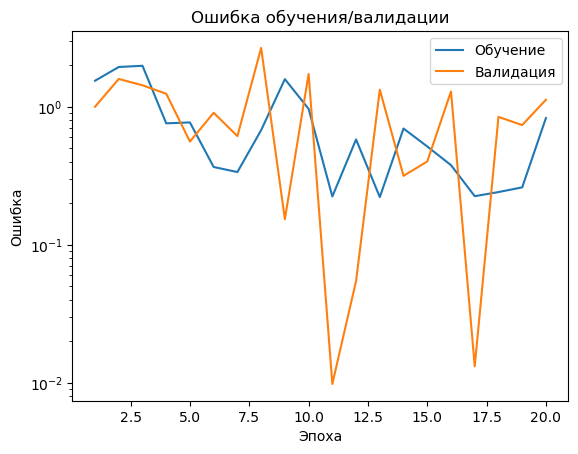

In [15]:
plt.title('Ошибка обучения/валидации')
plt.plot(np.arange(1, EPOCH_NUM+1, dtype=np.int16), train_loss_history, label='Обучение')
plt.plot(np.arange(1, EPOCH_NUM+1, dtype=np.int16), val_loss_history, label='Валидация')
plt.xlabel('Эпоха')
plt.ylabel('Ошибка')
plt.legend()
plt.semilogy()

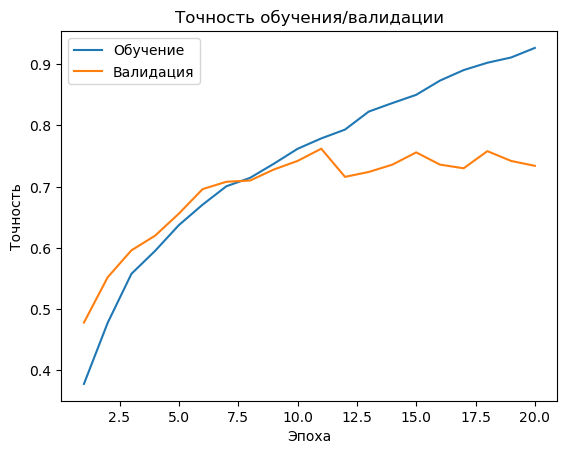

In [16]:
plt.title('Точность обучения/валидации')
plt.plot(np.arange(1, EPOCH_NUM+1, dtype=np.int16), train_acc_history, label='Обучение')
plt.plot(np.arange(1, EPOCH_NUM+1, dtype=np.int16), val_acc_history, label='Валидация')
plt.xlabel('Эпоха')
plt.ylabel('Точность')
plt.legend()

### Наблюдение

На графике ошибке по эпохам сложно увидеть, происходит обучение или нет, но если смотреть на точность, то можно увидеть, что точность растёт при обучении, но точность валидации в один момент выходит на плато. Момент выхода на плато можно взять как итоговую модель. Чтобы проверить, что ошибка снижается, построим график ошибки на каждой итерации

In [17]:
train_acc_history = []
val_acc_history = []
train_loss_history = []
val_loss_history = []
EPOCH_NUM = 20
model = ResNet18(3).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
for epoch in range(EPOCH_NUM):
    train_correct = 0
    train_predicted = 0
    model.train()
    
    for images, labels, _ in tqdm(desc=f"Training epoch {epoch +1}", iterable=train_data_loader):
        optimizer.zero_grad()
        # print(labels)
        logits = model(images)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        
        preds = logits.argmax(dim=-1)
        train_correct += (preds==labels).sum().item()
        train_predicted += labels.size(0)
            
        train_loss_history.append(loss.item())
        train_acc_history.append(train_correct / train_predicted)
    
    model.eval()
    val_correct = 0
    val_predicted = 0
    
    with torch.no_grad():
        for images, labels, _ in tqdm(iterable=val_data_loader, desc=f"Validating"):
            logits = model(images)
            loss = criterion(logits, labels)
            preds = logits.argmax(dim=-1)
            val_correct += (preds==labels).sum().item()
            val_predicted += labels.size(0)
            
            val_loss_history.append(loss.item())
            val_acc_history.append(val_correct / val_predicted)

Validating: 100%|██████████| 32/32 [00:00<00:00, 58.99it/s]


[]

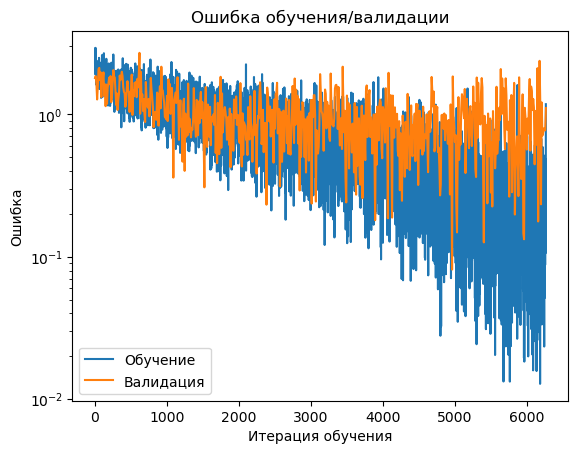

In [18]:
plt.title('Ошибка обучения/валидации')
plt.plot(np.arange(1, len(train_loss_history)+1, dtype=np.int16), train_loss_history, label='Обучение')
plt.plot(np.linspace(start=1, stop=len(train_loss_history)+1, num=len(val_loss_history), endpoint=True), val_loss_history, label='Валидация')
plt.xlabel('Итерация обучения')
plt.ylabel('Ошибка')
plt.legend()
plt.semilogy()

Здесь тоже можно видеть, что в один момент ошибка валидации начинает колебаться около определённого значения и больше не опускается, это происходит примерно на итерации 2000-3000